In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model

In [2]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

data.head(50)

data = data.fillna(method="ffill")

data.head(50)

print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

words=list(data['Word'].unique())
words.append("ENDPAD")
tags=list(data['Tag'].unique())

print("Unique tags are:", tags)

num_words = len(words)
num_tags = len(tags)

num_words

Unique words in corpus: 23007
Unique tags in corpus: 17
Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


23008

In [3]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences

len(sentences)

sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [4]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
word2idx

{'Thousands': 1,
 'of': 2,
 'demonstrators': 3,
 'have': 4,
 'marched': 5,
 'through': 6,
 'London': 7,
 'to': 8,
 'protest': 9,
 'the': 10,
 'war': 11,
 'in': 12,
 'Iraq': 13,
 'and': 14,
 'demand': 15,
 'withdrawal': 16,
 'British': 17,
 'troops': 18,
 'from': 19,
 'that': 20,
 'country': 21,
 '.': 22,
 'Families': 23,
 'soldiers': 24,
 'killed': 25,
 'conflict': 26,
 'joined': 27,
 'protesters': 28,
 'who': 29,
 'carried': 30,
 'banners': 31,
 'with': 32,
 'such': 33,
 'slogans': 34,
 'as': 35,
 '"': 36,
 'Bush': 37,
 'Number': 38,
 'One': 39,
 'Terrorist': 40,
 'Stop': 41,
 'Bombings': 42,
 'They': 43,
 'Houses': 44,
 'Parliament': 45,
 'a': 46,
 'rally': 47,
 'Hyde': 48,
 'Park': 49,
 'Police': 50,
 'put': 51,
 'number': 52,
 'marchers': 53,
 'at': 54,
 '10,000': 55,
 'while': 56,
 'organizers': 57,
 'claimed': 58,
 'it': 59,
 'was': 60,
 '1,00,000': 61,
 'The': 62,
 'comes': 63,
 'on': 64,
 'eve': 65,
 'annual': 66,
 'conference': 67,
 'Britain': 68,
 "'s": 69,
 'ruling': 70,
 'L

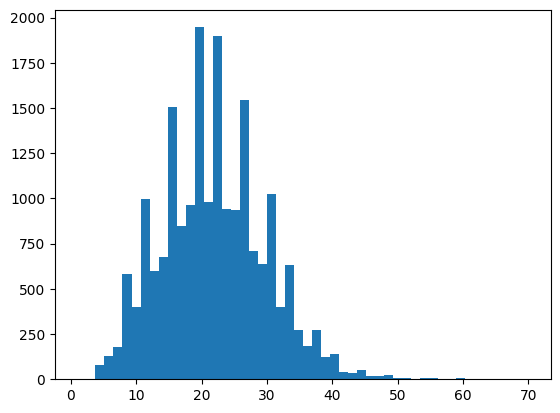

In [5]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()
X1 = [[word2idx[w[0]] for w in s] for s in sentences]
max_len = 50
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]

In [6]:
y = sequence.pad_sequences(maxlen=max_len,sequences=y1,padding="post",value=tag2idx["O"])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)
input_word = layers.Input(shape=(max_len,))
embedding_layer= layers.Embedding(input_dim=num_words,output_dim=50,input_length=max_len)(input_word)
dropout_layer=layers.SpatialDropout1D(0.1)(embedding_layer)
bidirectional_lstm=layers.Bidirectional(layers.LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(dropout_layer)
output=layers.TimeDistributed(layers.Dense(num_tags,activation="softmax"))(bidirectional_lstm)
model = Model(input_word, output)

In [8]:
model.summary()
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=32,
    epochs=3,
)

metrics = pd.DataFrame(model.history.history)
metrics.head()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1150400   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                             

,loss,accuracy,val_loss,val_accuracy
0,0.299407,0.937234,0.143175,0.955579
1,0.100190,0.971893,0.075500,0.978609
2,0.055936,0.984194,0.061065,0.982692


MOHAMED ASIL M
212222230080


<Axes: >

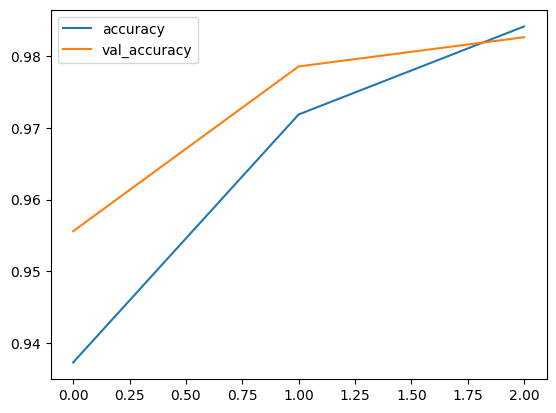

In [10]:
print("MOHAMED ASIL M")
print("212222230080")
metrics[['accuracy','val_accuracy']].plot()

MOHAMED ASIL M
212222230080


<Axes: >

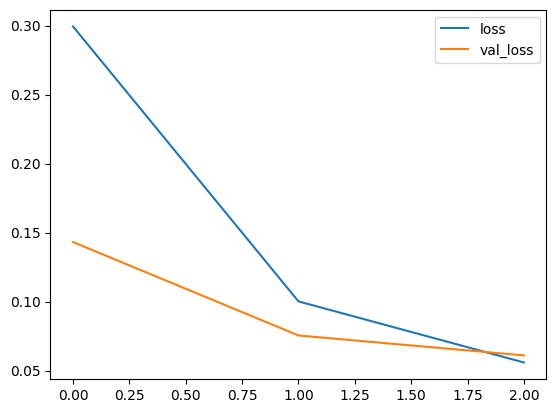

In [11]:
print("MOHAMED ASIL M")
print("212222230080")
metrics[['loss','val_loss']].plot()

In [13]:
print("MOHAMED ASIL M")
print("212222230080")
i = 20
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

MOHAMED ASIL M
212222230080
1/1 [==============================] - 1s 613ms/step
Word           True 	 Pred

------------------------------
She            O	O
said           O	O
in             O	O
the            O	O
statement      O	O
that           O	O
Burmese        B-gpe	B-gpe
people         O	O
need           O	O
to             O	O
establish      O	O
political      O	O
and            O	O
social         O	O
networks       O	O
to             O	O
achieve        O	O
"              O	O
national       O	O
reconciliation O	O
as             O	O
well           O	O
as             O	O
a              O	O
truly          O	O
united         O	O
spirit         O	O
.              O	O
"              O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O	O
Swing          O